<a href="https://colab.research.google.com/github/JennaKvasnovsky/AvalancheAlert/blob/main/Avalanche_Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install wandb
!apt-get install poppler-utils
!pip install pdf2image
!pip install flashtorch
import requests
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np
import torch
import requests
from torchvision import *
from torchvision.models import *
import wandb as wb

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=device)

def GPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=device)

def plot(x):
    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(5, 5)
    plt.show()

def get_google_slide(url):
    url_head = "https://docs.google.com/presentation/d/"
    url_body = url.split('/')[5]
    page_id = url.split('.')[-1]
    return url_head + url_body + "/export/pdf?id=" + url_body + "&pageid=" + page_id

def get_slides(url):
    url = get_google_slide(url)
    r = requests.get(url, allow_redirects=True)
    open('file.pdf', 'wb').write(r.content)
    images = convert_from_path('file.pdf', 500)
    return images

def load(image, size=224):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
    tensor = transform(image).unsqueeze(0).to(device)
    tensor.requires_grad = True
    return tensor



In [3]:
labels = {int(key):value for (key, value) in requests.get('https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json').json().items()}

model = alexnet(weights='DEFAULT').to(device)
model.eval();

In [4]:
url = "https://docs.google.com/presentation/d/1VCm2VcFhpEISGbaMAU13tInZOcuI5w2qtCj1ZeBKtAM/edit#slide=id.p"

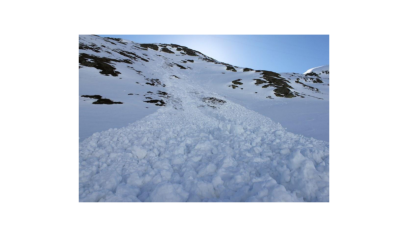

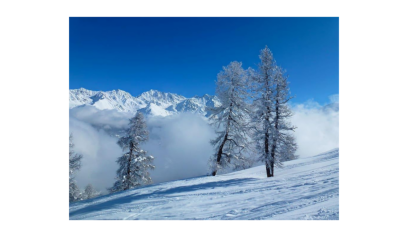

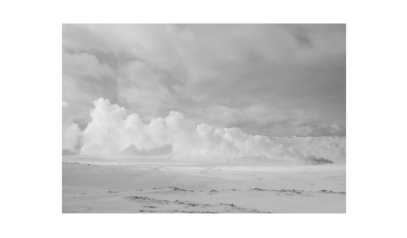

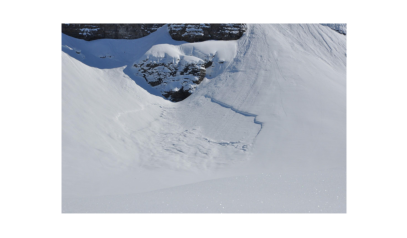

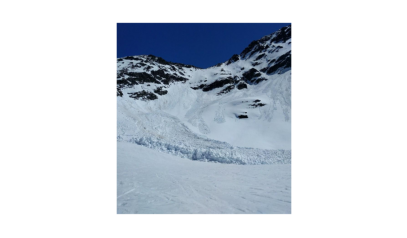

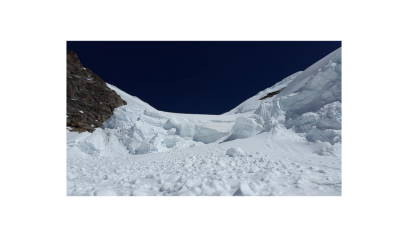

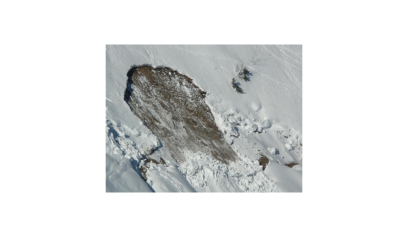

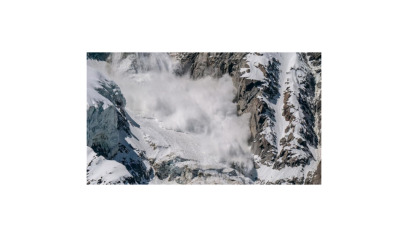

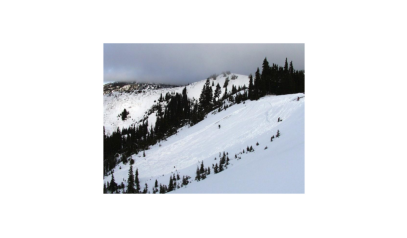

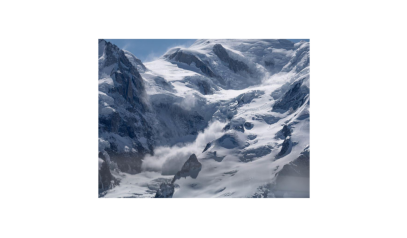

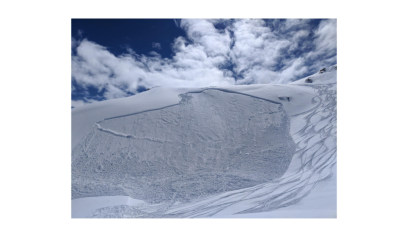

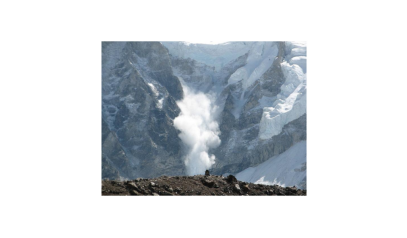

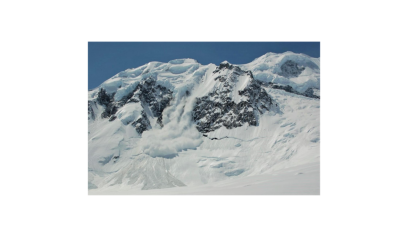

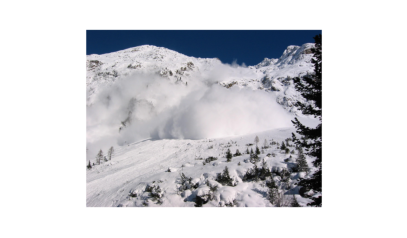

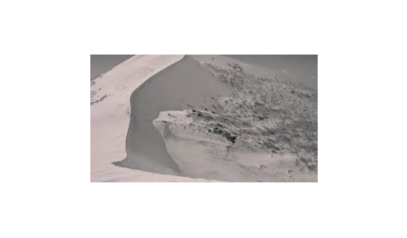

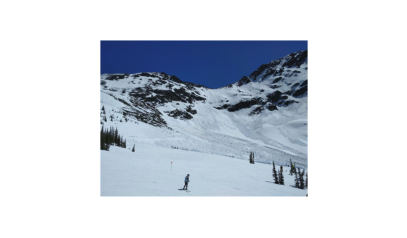

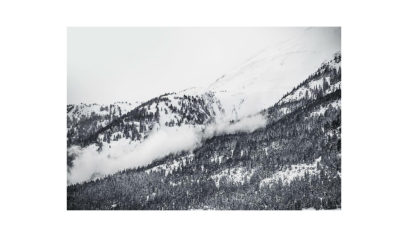

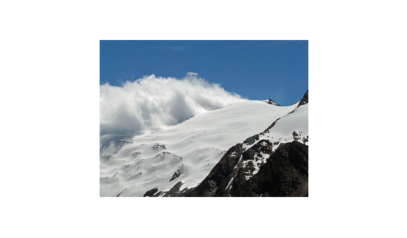

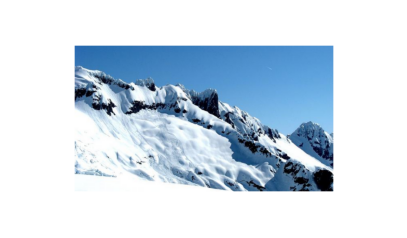

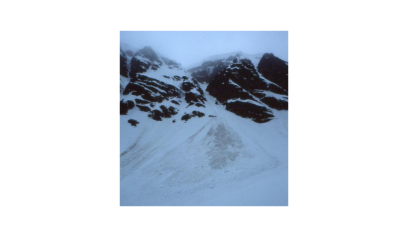

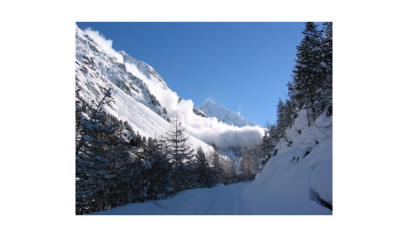

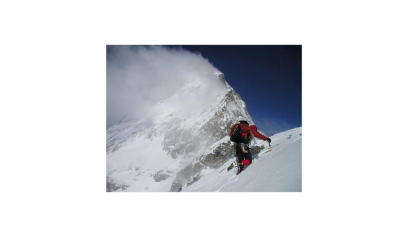

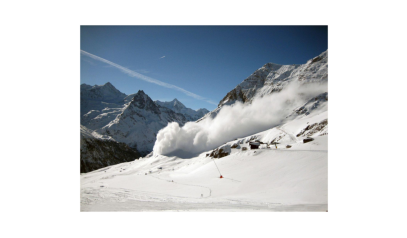

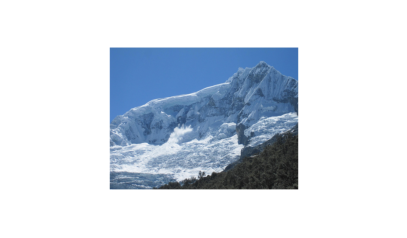

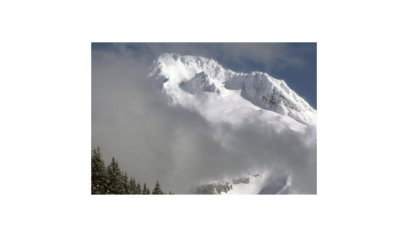

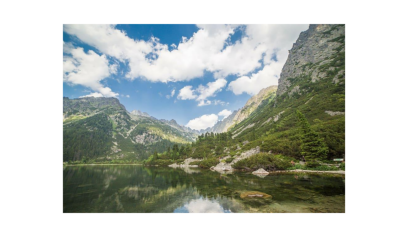

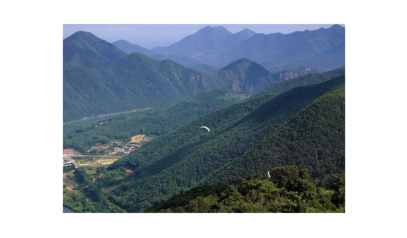

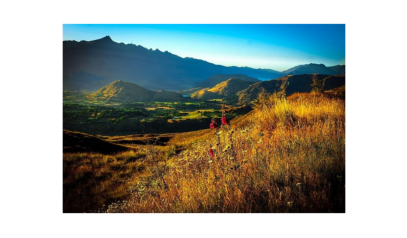

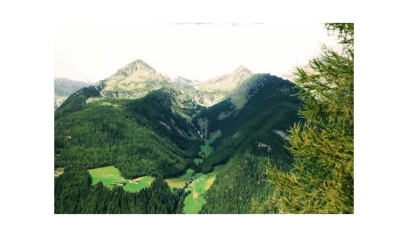

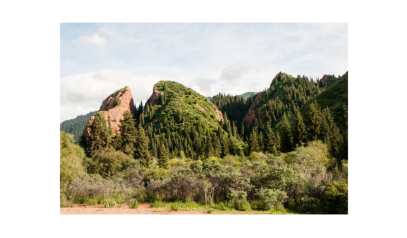

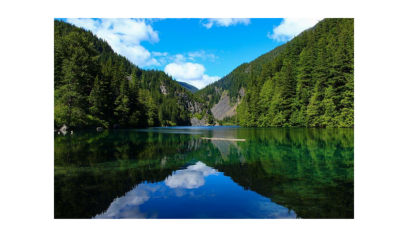

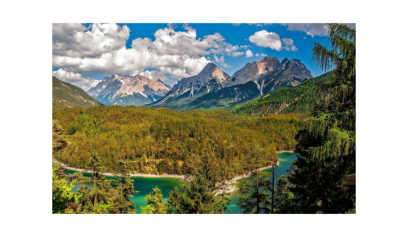

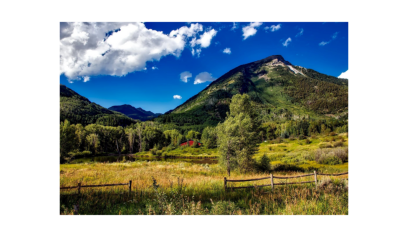

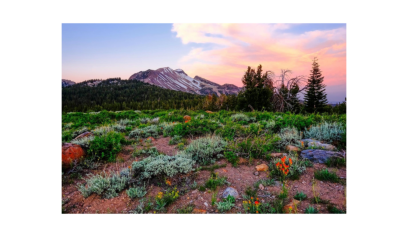

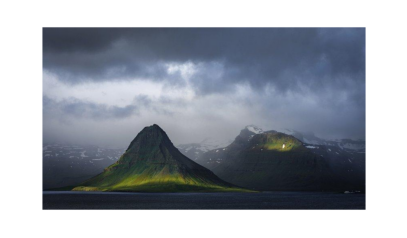

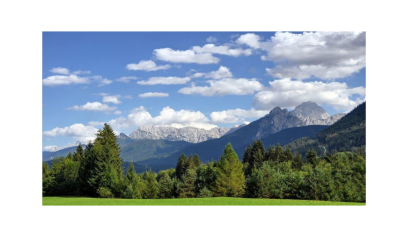

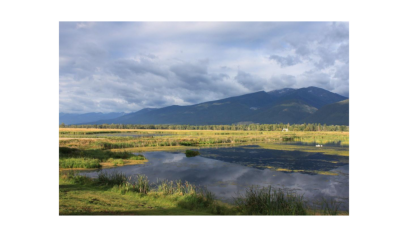

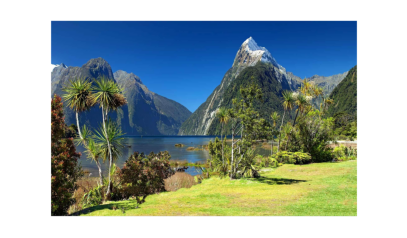

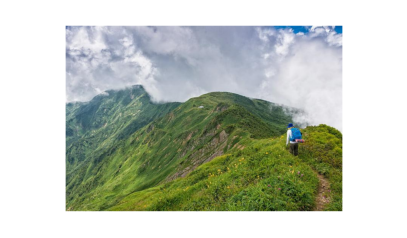

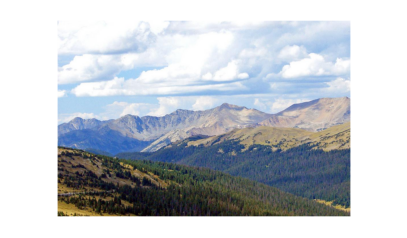

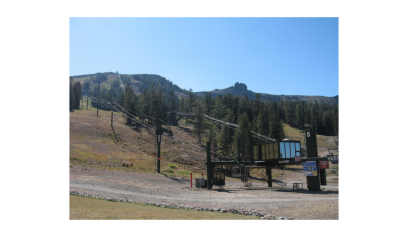

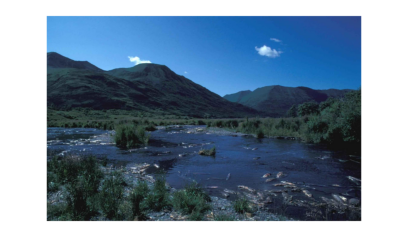

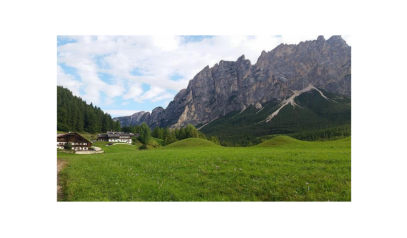

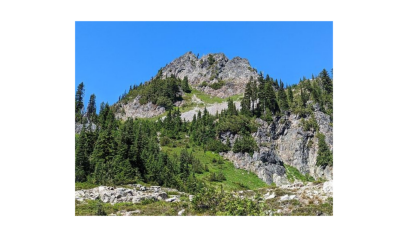

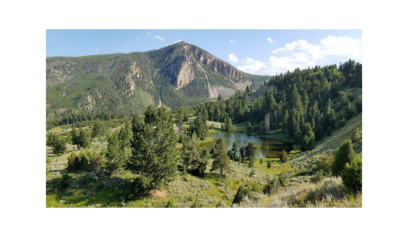

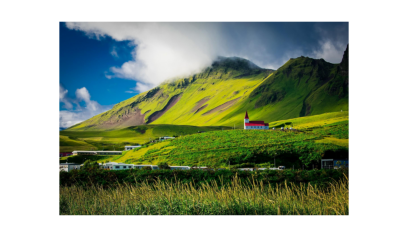

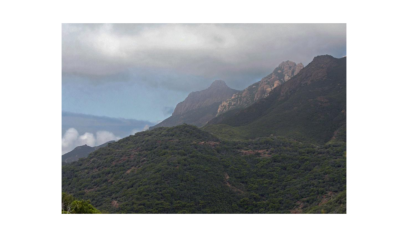

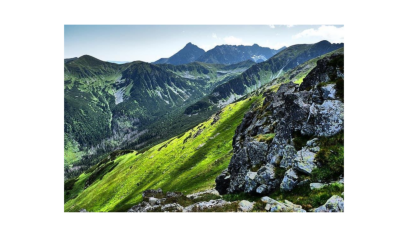

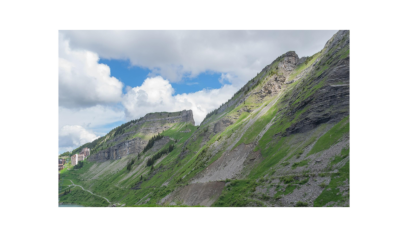

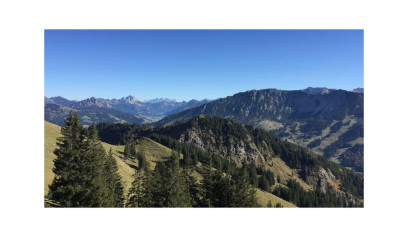

In [5]:
images = []

for image in get_slides(url):

    plot(image)

    images.append(load(image))

images = torch.vstack(images)

In [6]:
images.shape

torch.Size([50, 3, 224, 224])

In [7]:
model(images)

tensor([[-0.9226, -3.9417,  1.8275,  ..., -5.7730, -0.2893, -2.2418],
        [-1.1321, -1.0806,  2.8416,  ..., -5.6312,  0.3215,  1.7718],
        [-0.6245, -3.4645,  1.3300,  ..., -7.3444, -1.3012,  1.6411],
        ...,
        [-2.0942, -1.7323, -1.0018,  ..., -1.8089,  5.0337, -1.5451],
        [ 0.9293, -3.9430, -3.4233,  ..., -1.8708,  5.8091, -3.4143],
        [-0.1017, -1.9059, -0.0465,  ..., -3.5444,  2.8984, -1.9134]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [8]:
y = model(images)

In [9]:
y.shape

torch.Size([50, 1000])

In [10]:
guesses = torch.argmax(y, 1).cpu().numpy()

In [11]:
for i in list(guesses):
    print(labels[i])

alp
alp
seashore, coast, seacoast, sea-coast
envelope
dogsled, dog sled, dog sleigh
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus
lynx, catamount
alp
chain saw, chainsaw
alp
alp
alp
alp
alp
mountain tent
alp
ski
alp
alp
snowmobile
alp
ski
alp
alp
alp
valley, vale
valley, vale
barn
valley, vale
cliff, drop, drop-off
valley, vale
alp
barn
lakeside, lakeshore
volcano
valley, vale
viaduct
valley, vale
valley, vale
valley, vale
cliff, drop, drop-off
promontory, headland, head, foreland
alp
cliff, drop, drop-off
valley, vale
rapeseed
promontory, headland, head, foreland
alp
valley, vale
alp


In [12]:
#Y = np.zeros(100,)
#Y[50:] = 1

In [13]:
Y = np.zeros(50,)
Y[25:] = 1

In [14]:
X = y.detach().cpu().numpy()

In [15]:
X.shape

(50, 1000)

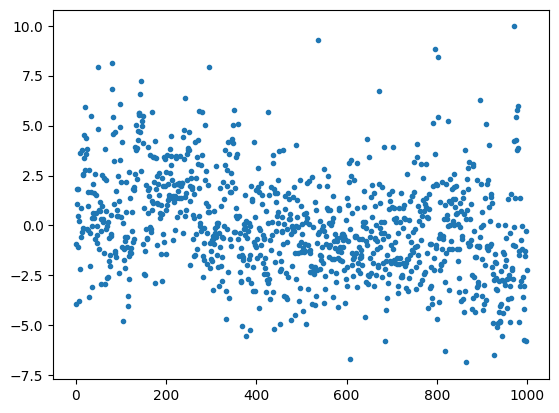

In [16]:
plt.plot(X[0],'.')

(array([ 11.,  61., 163., 276., 234., 142.,  74.,  29.,   6.,   4.]),
 array([-6.85705853, -5.17526579, -3.49347305, -1.81168032, -0.12988758,
         1.55190516,  3.23369789,  4.91549063,  6.59728336,  8.27907562,
         9.96086884]),
 <BarContainer object of 10 artists>)

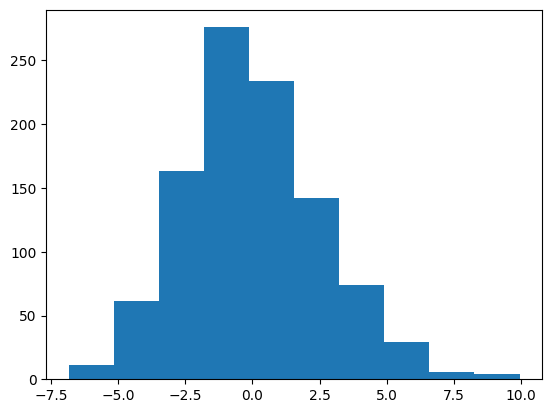

In [17]:
plt.hist(X[0])

In [18]:
X = GPU_data(X)
Y = GPU_data(Y)

In [19]:
def softmax(x):
    s1 = torch.exp(x - torch.max(x,1)[0][:,None])
    s = s1 / s1.sum(1)[:,None]
    return s

In [20]:
def cross_entropy(outputs, labels):
    return -torch.sum(softmax(outputs).log()[range(outputs.size()[0]), labels.long()])/outputs.size()[0]

In [21]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [22]:
def Truncated_Normal(size):

    u1 = torch.rand(size)*(1-np.exp(-2)) + np.exp(-2)
    u2 = torch.rand(size)
    z  = torch.sqrt(-2*torch.log(u1)) * torch.cos(2*np.pi*u2)

    return z

In [23]:
def acc(out,y):
    with torch.no_grad():
        return (torch.sum(torch.max(out,1)[1] == y).item())/y.shape[0]

In [24]:
X.shape

torch.Size([50, 1000])

In [25]:
def get_batch(mode):
    b = c.b
    if mode == "train":
        r = np.random.randint(X.shape[0]-b)
        x = X[r:r+b,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:]
        y = Y_test[r:r+b]
    return x,y

In [26]:
def model(x,w):

    return x@w[0]

In [27]:
def make_plots():

    acc_train = acc(model(x,w),y)

    # xt,yt = get_batch('test')

    # acc_test = acc(model(xt,w),yt)

    wb.log({"acc_train": acc_train})

In [28]:
wb.init(project="oh-ya");
c = wb.config

c.h = 0.001
c.b = 32
c.epochs = 100000

w = [GPU(Truncated_Normal((1000,2)))]

optimizer = torch.optim.Adam(w, lr=c.h)

for i in range(c.epochs):

    x,y = get_batch('train')

    loss = cross_entropy(softmax(model(x,w)),y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    wb.log({"loss": loss})

    make_plots()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-2-13a1dae5b345>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, requires_grad=True, dtype=torch.float, device=device)
